In this notebook, the scope initiation strategy to start with high- performing samples in the first round will be evaluated.

In [ ]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..','..','..')))
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from Code.benchmark import Benchmark
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import colorsys


# Doyle colors
doyle_colors = ["#CE4C6F", "#1561C2", "#188F9D","#C4ADA2","#515798", "#CB7D85", "#A9A9A9"]
# extension of palette with lighter and darker versions
def adjust_lightness(color, factor=1.2):
    """
    Function to make colors lighter (factor > 1) or darker (factor < 1).
    """
    r, g, b = mcolors.to_rgb(color)
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    l = max(0, min(1, l * factor))
    r, g, b = colorsys.hls_to_rgb(h, l, s)
    return mcolors.to_hex((r, g, b))

lighter = [adjust_lightness(c, 1.2) for c in doyle_colors]
darker  = [adjust_lightness(c, 0.7) for c in doyle_colors]
all_colors = doyle_colors + darker[::-1] + lighter[::-1] 

# Save the categorical colormap
cat_cmap = ListedColormap(all_colors, name="Doyle_cat")
plt.colormaps.register(cat_cmap)

# Define and save a continuous colormap
colors = [doyle_colors[1],"#FFFFFFD1",doyle_colors[0]]
cont_cmap = LinearSegmentedColormap.from_list("Doyle_cont", colors)
plt.colormaps.register(cont_cmap)

wdir = Path(".")

# General plt parameters
plt.rcParams.update({
    "axes.titlesize": 20,        # Subplot title
    "axes.labelsize": 16,        # X and Y labels
    "figure.titlesize": 24,      # Suptitle
    "xtick.labelsize": 14,       # X tick labels
    "ytick.labelsize": 14,       # Y tick labels
    "legend.fontsize": 14,       # Legend text
    "legend.title_fontsize": 14  # Legend titles
})

In [2]:
# define a running variable with the datasets
datasets = ["high","medium","low"]
# load the distribution metrics for the standardization
df_bounds = pd.read_csv("./../Amide_data/Datasets/bounds_subs.csv",index_col=0)
# define a function to extract the relevant means and stdev's in a format suitable for the Benchmark class
# define a function to extract the relevant bounds in a format suitable for the Benchmark class
def get_bounds(dset):
    bounds = {}
    # get the metrics for the rate objective
    bounds["yield"] = (df_bounds.loc["obj_max",dset],df_bounds.loc["obj_min",dset])
    # get the metrics for the vendi score
    bounds["vendi"] = (df_bounds.loc["vendi_max",dset],df_bounds.loc["vendi_min",dset])

    return bounds



In [3]:
dfs_raw_data = {}
for dset in datasets:
    # get the data for the inidividual seeds
    _, dfs_raw_data[dset] = Benchmark.get_metric_overview(bounds=get_bounds(dset),budget=27,type_results="scope", 
                                name_results=f"./Results_Data/{dset}-dataset/ei_with-pruning")
    # dfs_raw_data[dset] contains a dict for all batch-pruning combination with another dict as 
    # the value which contains the data for the random seeds
    # here, we only have one combination (b3_V13 --> optimized hyperparameters)
    # --> reassign dfs_raw_data[dset] for simplier handling
    dfs_raw_data[dset] = dfs_raw_data[dset]["b3_V13"]

In [4]:
# illustration of the structure of the dfs in dfs_raw_data[dset], the keys of dfs_raw_data are the seeds and the values the data
# in the dfs, the indices are the rounds of experiments
print("Example dataframe to visualize the structure:")
dfs_raw_data["high"][0]

Example dataframe to visualize the structure:


,vendi,yield,scope
0,1.692056,0.708680,-0.177500
1,2.201821,0.606445,-0.045309
2,2.906062,0.638245,0.001526
3,3.921806,0.626065,0.084349
4,4.521911,0.626059,0.133370
5,4.993164,0.610133,0.144881
6,5.364138,0.629386,0.208809
7,6.087863,0.602206,0.199848
8,6.543820,0.633183,0.319521


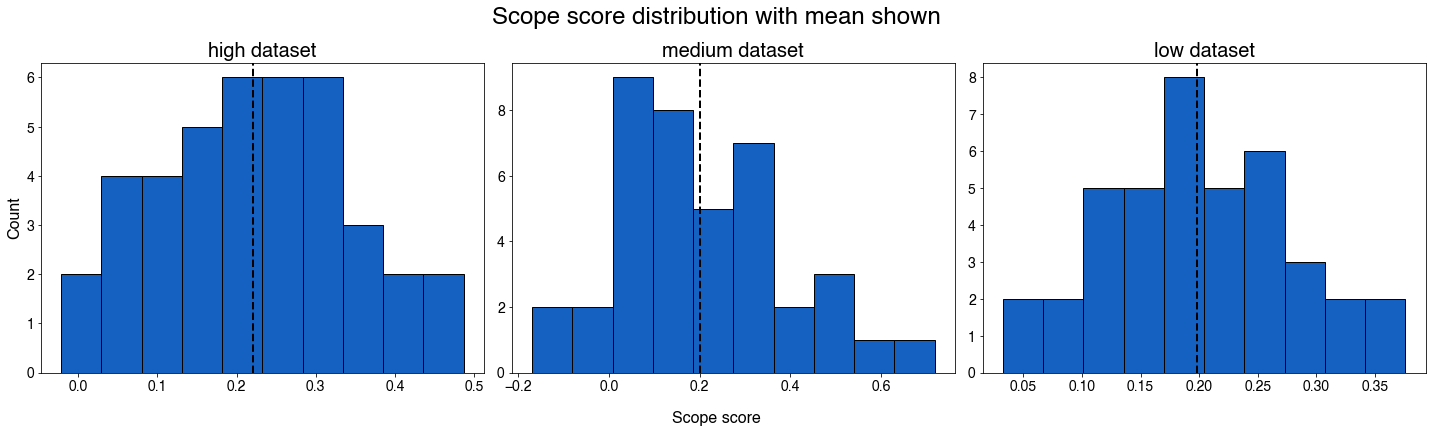

In [5]:
# get and plot the final scope scores for the inidividual seeds
nr_seeds = len(dfs_raw_data["high"])  # NOTE: same number of seeds for all datasets
score_dict = {}
mean_scores = {}
fig,axes = plt.subplots(1,3,figsize=(20,6))
fig.suptitle("Scope score distribution with mean shown")
fig.supxlabel("Scope score",fontsize=16)
for i,dset in enumerate(datasets):
    score_list = [dfs_raw_data[dset][i].loc[8,"scope"] for i in range(nr_seeds)]
    score_dict[dset] = score_list
    mean_score = np.mean(score_list)  # mean scope score
    mean_scores[dset] = mean_score
    axes[i].hist(score_list, color=all_colors[1], bins=10, edgecolor="k")
    mean_line = axes[i].axvline(x=mean_score, color='black', linestyle='--', linewidth=2)
    axes[i].set_title(f"{dset} dataset")
    axes[i].set_ylabel("")
axes[0].set_ylabel("Count")
plt.tight_layout()
plt.show()


In [6]:
# get lists for the metrics of the initial samples
initial_vendi = {}
initial_obj = {}

# check: How are the final scope scores when the initiations with the highest initial average rates are regarded?
summ_top_yields = pd.DataFrame(np.nan,index=datasets,columns=["Mean final scope score",
                                                            "Worst final scope score",
                                                            "Mean final scope score top5 initial av. yield",
                                                            "Worst final scope score top5 initial av. yield",
                                                            "Mean initial average yield",
                                                            "Mean top5 initial yield"])
best_init_final_scope = {}
best_init_yield = {}
for dset in datasets:
    initial_vendi[dset] = [dfs_raw_data[dset][i].loc[0,"vendi"] for i in range(nr_seeds)]
    initial_obj[dset] = [dfs_raw_data[dset][i].loc[0,"yield"] for i in range(nr_seeds)]

    summ_top_yields.loc[dset,"Mean initial average yield"] = round(np.mean(initial_obj[dset]),3)
    summ_top_yields.loc[dset,"Mean final scope score"] = round(np.mean(np.array(score_dict[dset])),3)
    summ_top_yields.loc[dset,"Worst final scope score"] = round(np.min(np.array(score_dict[dset])),3)


    # get the seeds that have the top 5 initial average rates
    indexed_rates = list(enumerate(initial_obj[dset]))  # generate (index,av. yield) tuples
    top_5 = sorted(indexed_rates, key=lambda x: x[1], reverse=True)[:5]  # sort by score
    best_seeds = [index for index, yield_val in top_5]
    print(f"Top 5 seeds by initial average yield ({dset} dataset):", best_seeds)

    # get the averages of the final samples for the top 5 seeds
    best_init_final_scope[dset] = [dfs_raw_data[dset][i].loc[8,"scope"] for i in best_seeds]
    best_init_yield[dset] = [initial_obj[dset][i] for i in best_seeds]

    summ_top_yields.loc[dset,"Mean final scope score top5 initial av. yield"] = round(np.mean(best_init_final_scope[dset]),3)
    summ_top_yields.loc[dset,"Worst final scope score top5 initial av. yield" \
    "" \
    ""] = round(np.min(best_init_final_scope[dset]),3)
    summ_top_yields.loc[dset,"Mean top5 initial yield"] = round(np.mean(best_init_yield[dset]),3)

summ_top_yields

Top 5 seeds by initial average yield (high dataset): [33, 12, 19, 27, 3]
Top 5 seeds by initial average yield (medium dataset): [13, 12, 34, 23, 25]
Top 5 seeds by initial average yield (low dataset): [16, 34, 18, 33, 32]


,Mean final scope score,Worst final scope score,Mean final scope score top5 initial av. yield,Worst final scope score top5 initial av. yield,Mean initial average yield,Mean top5 initial yield
high,0.220,-0.022,0.250,0.129,0.632,0.800
medium,0.199,-0.170,0.157,0.028,0.395,0.572
low,0.198,0.033,0.157,0.057,0.219,0.345


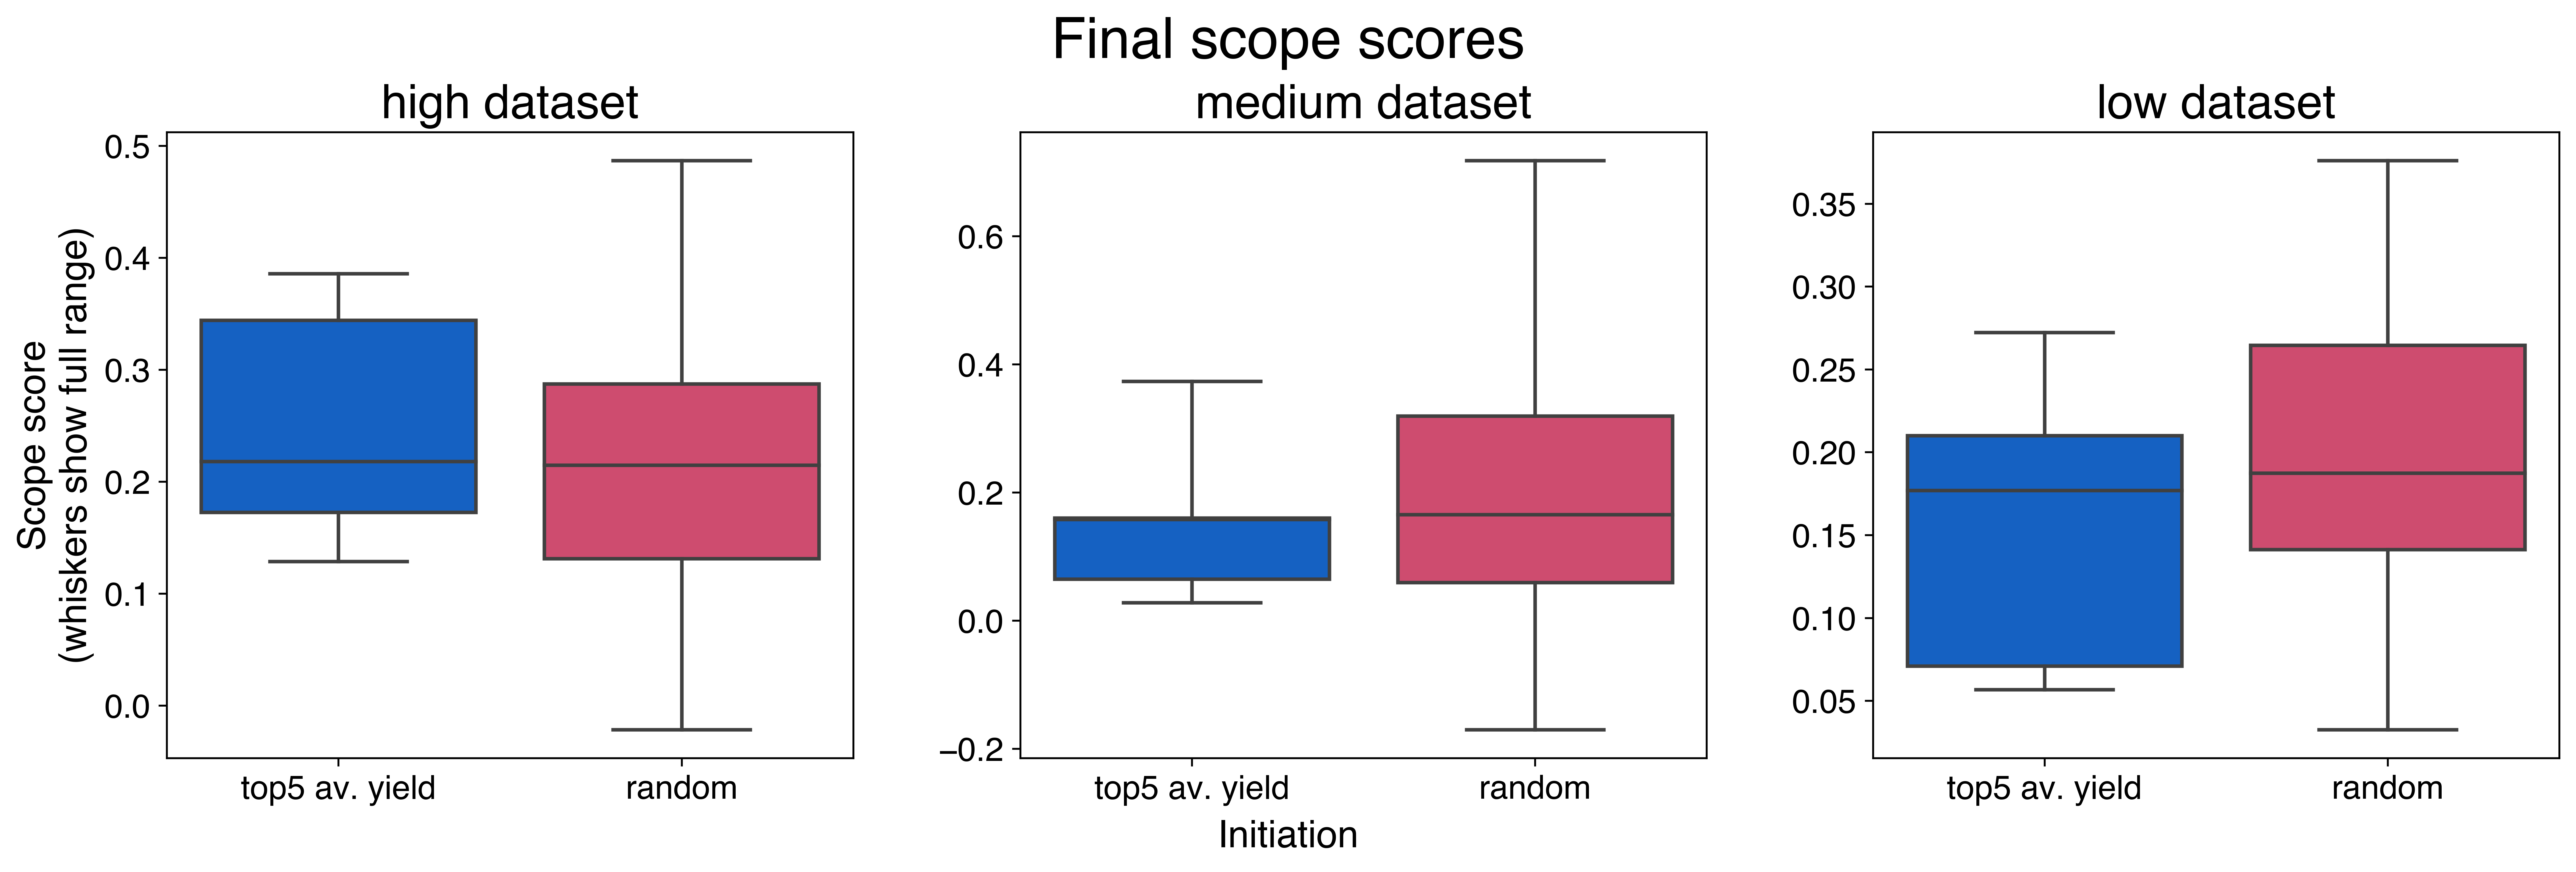

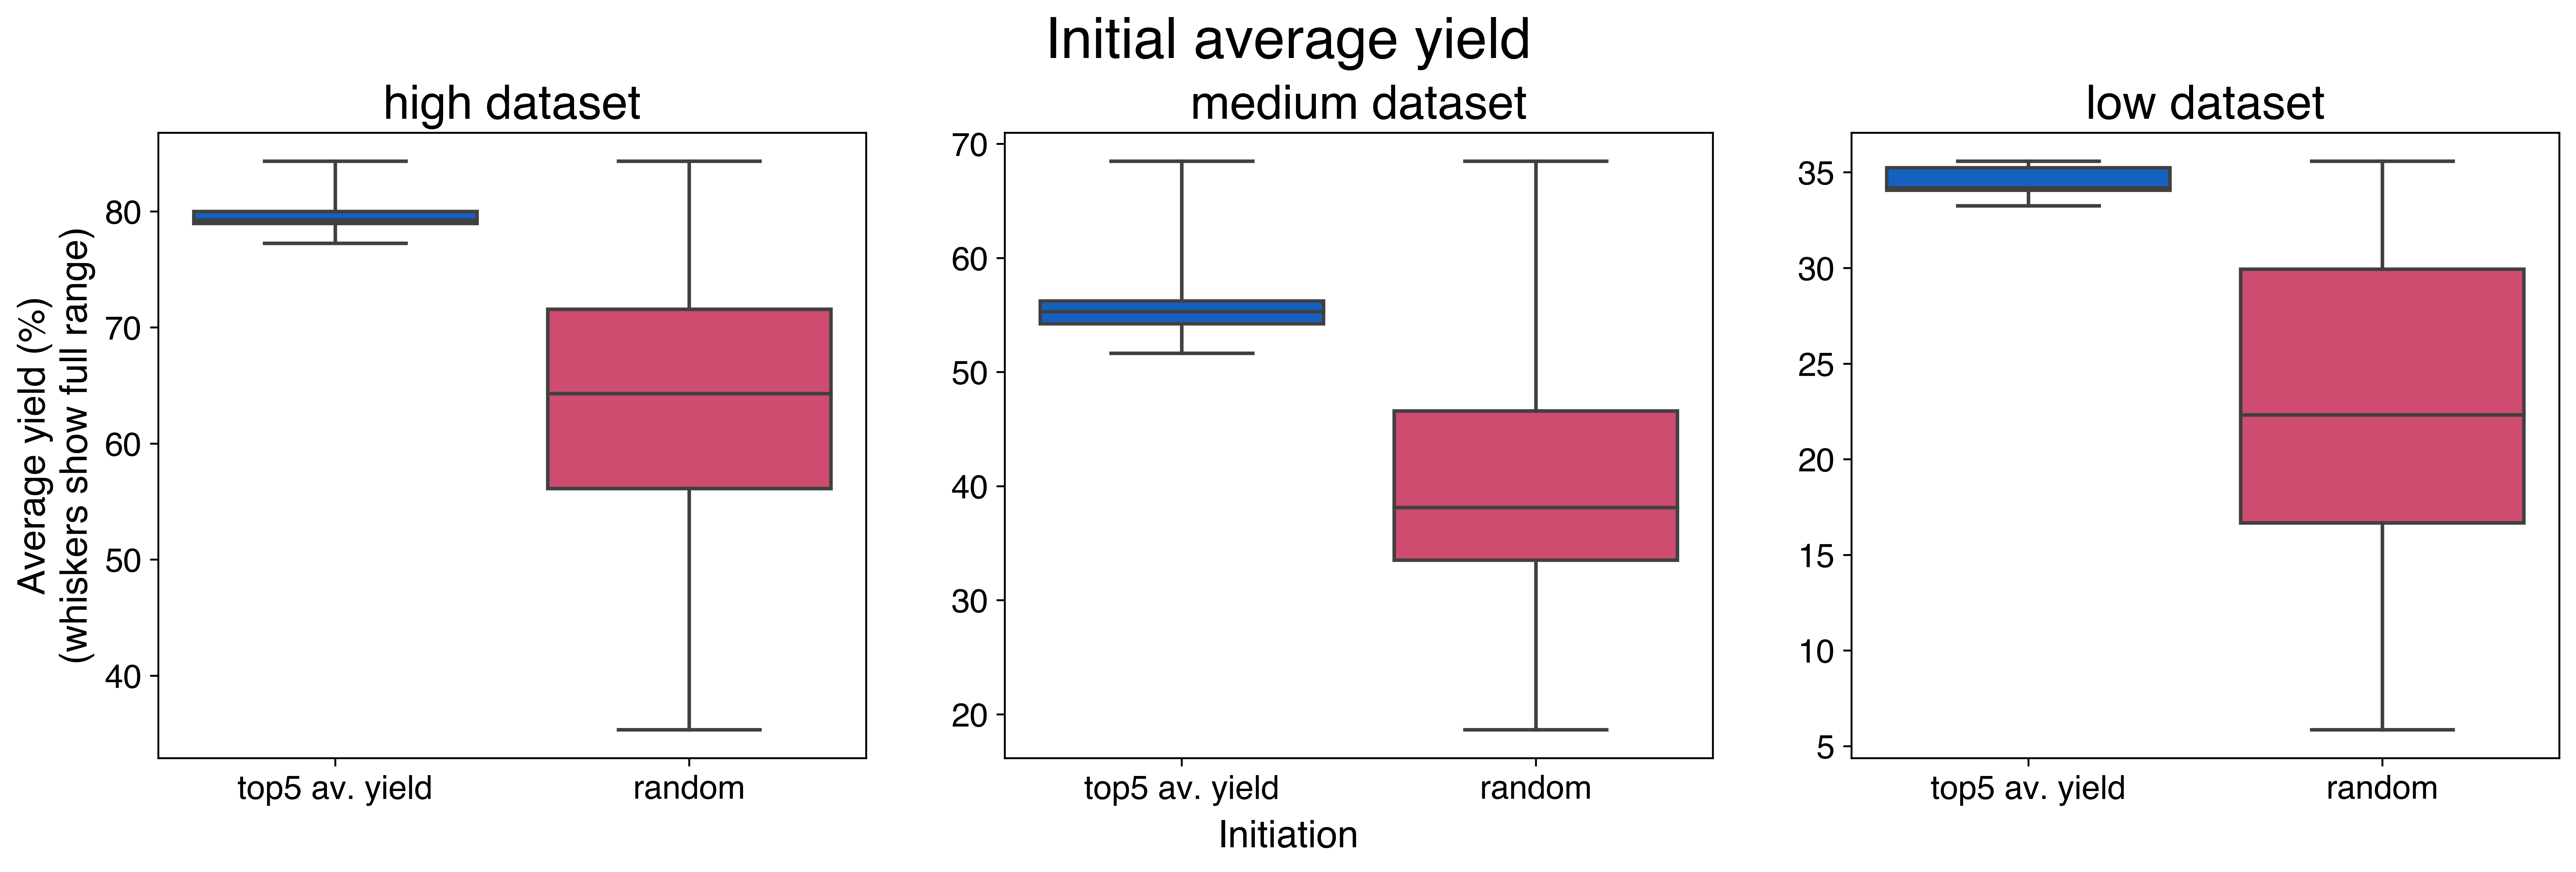

In [10]:
for results_type in ["scope","yield"]:
    fig,axes = plt.subplots(1,3,figsize=(15,5),gridspec_kw={"wspace": 0.1},constrained_layout=True,dpi=600)
    if results_type == "scope":
        fig.suptitle("Final scope scores")
    else:
        fig.suptitle("Initial average yield")
    fig.supxlabel("Initiation",fontsize=16)
    for i,dset in enumerate(datasets):
        if results_type == "scope":
            df = pd.DataFrame([best_init_final_scope[dset],score_dict[dset]])
        else:
            df = pd.DataFrame([best_init_yield[dset],initial_obj[dset]]).applymap(lambda x: x*100)
        df_long = df.T.melt(var_name='Row', value_name='Value')
        df_long.loc[df_long["Row"] == 0,"Row"] = "top5 av. yield"
        df_long.loc[df_long["Row"] == 1,"Row"] = "random"
        ax = axes[i]
        palette = [all_colors[1], all_colors[0]]
        sns.boxplot(ax=ax,x='Row', y='Value', data=df_long, whis=[0,100], palette=palette, saturation=1)
        if i == 0 and results_type == "scope":
            ax.set_ylabel('Scope score\n(whiskers show full range)')
        elif i == 0 and results_type == "yield":
            ax.set_ylabel("Average yield (%)\n(whiskers show full range)")
        else:
            ax.set_ylabel("")
        ax.set_xlabel("")
        ax.set_title(f'{dset} dataset')
    plt.show()

While the median performance between random initiation and high-performance initiation is very similar, the worst case scope score is improved with the high-performance strategy for all datasets. The effect is very minimal for the low dataset, but more pronounced for the the other two datasets.